## 1 개념
 - 알렉스 넷은 이미지의 특징 추출에 합성곱과 맥스 풀링 사용 후 FC 계층을 통해 클래스를 분류
 - 순전파 과정에서 피처맵의 차원 수 증가, 크기 감소
 - 합성공 모델은 피처맵의 차원수가 늘어날 수록 모델의 표현력이 증가하며, 특징 맵의 크기를 줄여 연산량 감소

### LeNet-5 구조
- 1개의 입력층(I), 2개 합성곱층(C1, C3), 2개의 서브샘플링 계층(S2, S4), 1개의 FC층(FC5)와 1개의 출력층으로 구성
 - 서브샘플링 방법으로는 평균값 풀링 적용
 - 활성화 함수는 출력층에서는 Sigmoid, 나머지는 tanh(하이퍼볼릭 탄젠트) 사용

### AlexNet 구조
 - 1개의 입력층(I), 5개의 합성곱층(C1, C3, C5, C6, C7), 3개의 서브샘플링 계층(S2, S4, S8), 3개의 FC 층(FC9, FC10, FC11), 1개의 출력층(O)으로 구성
 - I → C1 → S2 → C3 → S4 → C5 → C6 → C7 → S8 → FC9 → FC10 → FC11 (= O)
 - 서브샘플링 방법으로 최대 풀링적요
 - 활성화 함수는 ReLU 적용

### AlexNet과 LeNet-5 차이
 - 입력이미지 크기, 활성화 함수, 풀링 방식과 드롭아웃 추가한 내용임

## 2 모델 학습

In [1]:
# 모델 요약
from torchvision import models
from torchinfo import summary

input_data = (1, 3, 224, 224) # 배치사이즈 1, 채널 3, 입력크기(H, W)
model = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1") # AlexNet 구조 + ImageNet으로 학습된 가중치를 함께 로드 -> 마지막 출력이 1000
summary(model, input_data, device="cpu")

# ReLU까지 표현되어 나옴
"""
nn.Conv2d(
    in_channels=3, # input_data = (1, 3, 224, 224)에서 3
    out_channels=64, # Conv2d: 2-1       [1, 64, 55, 55]            Param # 23,296 = 64 * 364 = 23,296
    kernel_size=11,
    stride=4,
    padding=0
)
파라미터 수 23,296개인 이유

입력:  (1, 3, 224, 224)
Conv1: (1, 64, 55, 55)
kernel_size = 11 × 11
stride = 4

Conv2d 파라미터 수 = out_channels * (in_channels * kH * kW  + bias) = 커널 수 * 커널 하나의 파라미터 수 = 64 * 364 = 23,296
커널 1개의 파라미터 수: 364개
가중치 = 3x11x11 = 363
입력채널 :3
커널 크기 : 11 x 11
bias: 1
커널 수: 64개
"""

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

---
### 알렉스넷의 채널, 커널 수, 파라미터 수 파악하기
---
- **출력 채널 수 = 커널 수 = 특징맵 수**
#### C1에서 
- 커널은(Shape)? 3 x 11 x 11 이다. 왜? : (in_channels, kH, kW) = (3, 11, 11)
- C1에서 커널 수는 64다 왜? : out_channels = 64
- C1에서 파라미터는 Param # 23,296 = 64 * 364 = 23,296 왜?
- 커널은 가중치(3 × 11 × 11 = 363)이며 편향은 커널마다 하나씩 따라 붙는다. 현재 1개의 커널에는 364개의 파라미터가 있음
- 커널이 64개이므로 C1에서 총 파라미터는 23,296개다.
#### C3에서 
- kernel_size = 5 × 5 이라면 커널의 shape? (64, 5, 5)
- C3에서 커널 수는? 192
- C3의 파라미터 수는 ? 가중치(64 * 5 * 5 = 1600) 편향 1을 더한 1601이며, 커널이 192 이므로 1601 × 192 = 307,392

#### C5에서
- C5의 커널 사이즈가 (3, 3)일때 커널 shape? (192, 3, 3)
- C5의 커널 수(특징맵)은? 384
- C3의 파라미터 수? 가중치: 192 x 3 x 3 = 1,728, 편향 1 => 커널 당 파라미터 수: 1,729, 커널 (284) 1,729 × 384 = 663,936
### C7 에서
- Conv2d: 2-9(즉 C7)의 Conv2d의 출력 특징맵의 텐서 shape가 [1, 256, 13, 13] 이고, Param이라면 884,992 이라면 커널 사이즈는 얼마인가?
- 거꾸로 계산해 보면, 총 파라미터 = 884,992이고 출력채널 수(커널 수) = 256  : 884,992 ÷ 256 = 3,457
- 여기서 편향 1개 제거 하면 3,457 − 1 = 3,456 개
- 입력채널 수로 나누면 3,456 ÷ 384 = 9, 따라서 커널 사이즈는 3 x 3, 이고 커널의 형태는 (384, 3, 3)임
#### FC9에서
 - 커널(뉴런)은? 바로 앞 레이어의 출력 [1, 256, 6, 6]을 Flatten 하면 1 * 256 * 6 * 6 = 9,216 이 입력이므로 뉴런 하나당 9,216차원 가중치 벡터를 가진다.
 - nn.Linear(in_features=9216, out_features=4096)
 - FC9의 커널 수는? 4096
 - FC9의 파라미터는? 가중치 9216 x 4096 = 37,748,736, 편향 4096 = 37,748,736 + 4,096 = 37,752,832 또는 (9216 + 1) * 4096 = 37,752,832
---
### 알렉스 넷에 사용된 계층 클래스 목록
---
#### 1 컨테이너 계층
- torch.nn.Sequential, 여러 계층을 묶는 컨테이너, features, classifier 구성에 사용
️#### 2  합성곱 계층: torch.nn.Conv2d
- 특징 추출용 핵심 계층, 총 5회 사용
#### 3. 활성화 함수
- torch.nn.ReLU, 비선형성 부여, Conv/Linear 뒤에 반복 사용
#### 4. 풀링 계층
- torch.nn.MaxPool2d, 공간 차원 축소, 3번 사용
- torch.nn.AdaptiveAvgPool2d 입력 크기와 무관하게 출력 크기 고정 (6×6) 1번 사용
#### 5 FC 층
- torch.nn.Linear, 분류기(Classifier) 구성, 3회 사용 (4096 → 4096 → 1000)
#### 6 정규화/일반화 계층
- torch.nn.Dropout, 과적합 방지, FC 앞단에서 사용

In [3]:
with open("../datasets/imagenet_classes.txt", "r") as file:
    classes = file.read().splitlines()
    
print(f"클래스 개수 : {len(classes)}")
print(f"첫 번째 클래스 레이블 : {classes[0]}") # tench는 잉어과의 **민물고기(영어명)**

클래스 개수 : 1000
첫 번째 클래스 레이블 : tench


In [5]:
import torch
from PIL import Image # PIL = Python Imaging Library
from torchvision import models, transforms

# 여러 개의 변환(transform)을 “순서대로” 적용하기 위한 컨테이너
# 입력: PIL Image -> torch.Tensor
# 순서는 입력 이미지를 ->  → Resize  → ToTensor → Normalize  → 모델 입력
# 전처리 파이프라인
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)), # 이미지 크기를 강제로 224 × 224로 변경
        transforms.ToTensor(), # PIL Image → torch.Tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], # 흑백이라면 [0.5],
            std=[0.229, 0.224, 0.225] # 흑백이라면 [0.5],
        ),
    ]
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.alexnet(weights="AlexNet_Weights.IMAGENET1K_V1").eval().to(device)

tensors = []
files = ["../datasets/images/airplane.jpg", "../datasets/images/bus.jpg"]
for file in files:
    image = Image.open(file)
    tensors.append(transform(image))
# 앞에 2개 이미지가 있는 리스트를 텐서로 변화
print(len(tensors))
print(f'지금 tensors 텐서일까 리스트일까? {type(tensors)}')

# 리스트를 텐서로 그냥 바꾸면 어떻게 될까?
# tensors = torch.tensor(tensors) 
# ValueError: only one element tensors can be converted to Python scalars

# 이미지 Tensor 2개를 새로운 차원(Batch)으로 쌓아 하나의 4D Tensor로 변환
tensors = torch.stack(tensors) 
# 이미지 Tensor 2개를 새로운 차원(Batch)으로 쌓아 하나의 4D Tensor로 변환
print(f"입력 텐서의 크기 : {tensors.shape}")
# 입력 텐서의 크기 : torch.Size([2, 3, 224, 224]) => (B 이미지 개수, C 채널 수, H, W)

2
지금 tensors 텐서일까 리스트일까? <class 'list'>
입력 텐서의 크기 : torch.Size([2, 3, 224, 224])


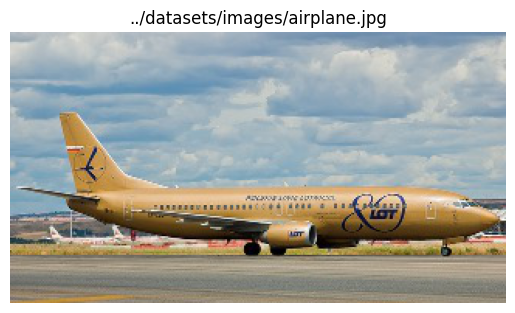

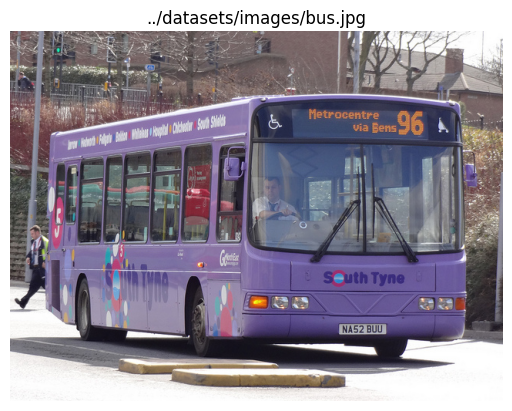

In [7]:
# 원본 이미지 보기
from PIL import Image
import matplotlib.pyplot as plt

files = ["../datasets/images/airplane.jpg", "../datasets/images/bus.jpg"]

for file in files:
    image = Image.open(file)
    plt.imshow(image)
    plt.title(file)
    plt.axis("off")
    plt.show()

In [9]:
import numpy as np
from torch.nn import functional as F


with torch.no_grad():
    outputs = model(tensors.to(device)) 
    # AlexNet이 각 이미지마다 1000개 클래스에 대한 점수(logits) 출력 
    # tensors.shape = [2, 3, 224, 224] =>  [2, 1000], logits은 softmax 전의 원시 점수 크면 클수록 해당 클래스일 가능성이 높음
    
    probs = F.softmax(outputs, dim=-1) # Softmax → 확률로 변환 각 행의 합 = 1.0 (100%)
    
    top_probs, top_idxs = probs.topk(5) # Top-5 클래스 추출

top_probs = top_probs.detach().cpu().numpy() # Tensor → NumPy 변환
top_idxs = top_idxs.detach().cpu().numpy()
top_classes = np.array(classes)[top_idxs]

for idx, (cls, prob) in enumerate(zip(top_classes, top_probs)):
    print(f"{files[idx]} 추론 결과")
    for c, p in zip(cls, prob):
        print(f" - {c:<30} : {p * 100:>5.2f}%")

# streetcar (노면전차)

../datasets/images/airplane.jpg 추론 결과
 - airliner                       : 73.50%
 - warplane                       : 14.41%
 - wing                           :  9.55%
 - space shuttle                  :  1.94%
 - missile                        :  0.25%
../datasets/images/bus.jpg 추론 결과
 - streetcar                      : 60.24%
 - trolleybus                     : 38.01%
 - minibus                        :  1.54%
 - passenger car                  :  0.17%
 - recreational vehicle           :  0.03%


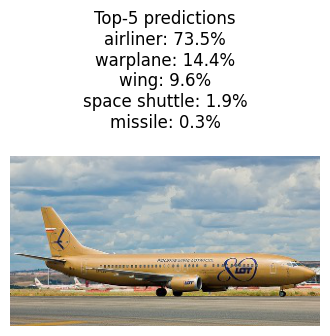

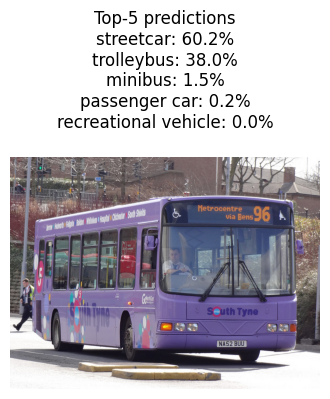

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

for idx, file in enumerate(files):
    # 1) 원본 이미지 열기
    img = Image.open(file)

    # 2) Top-5 결과 문자열 만들기
    title = f"Top-5 predictions\n"
    for c, p in zip(top_classes[idx], top_probs[idx]):
        title += f"{c}: {p*100:.1f}%\n"

    # 3) 이미지 출력
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()